In [170]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/.julia/dev/StableManipulation/Project.toml`


In [171]:
using LinearAlgebra
using ForwardDiff
using OrdinaryDiffEq
using Plots
using Convex, SCS
using JLD
using StableManipulation

In [172]:
include("../models/rod_corner_frictionless_concave.jl")

Main.RodWorld

In [173]:
dynamics! = RodWorld.ode_dynamics!
conditions = RodWorld.ode_conditions
affect! = RodWorld.ode_affect!
affect_neg! = RodWorld.ode_affect_neg!

domain = RodWorld.domain
guard_set = RodWorld.guard_set
jumpmap = RodWorld.jumpmap

const n_contacts = RodWorld.n_contacts
const Δt = RodWorld.Δt
const modes = RodWorld.modes
const n_modes = size(modes, 1)

const tol_c = RodWorld.tol_c


0.0005

In [239]:
# goal: hold the rod at 45 degrees at the corner
# xref = [cos(pi/4)*RodWorld.l/2; sin(pi/4)*RodWorld.l/2; pi/4; 0; 0; 0]
xref = [cos(pi/3)*RodWorld.l/2; sin(pi/3)*RodWorld.l/2; pi/3; 0; 0; 0] - [0.2,0,0,0,0,0] + [0,-0.02, 0,0,0,0]

nominal_mode = [true, true]

function wrench_control_2_body(x, control_u)
    u = [control_u[1]; control_u[2]; 
        control_u[3] - control_u[1]*sin(x[3])*RodWorld.l/2 + control_u[2]*cos(x[3])*RodWorld.l/2]
    return u
end

function control_discrete_dynamics(x, control_u, mode)
    u = wrench_control_2_body(x,control_u)
    xn = RodWorld.discrete_dynamics(x, u, mode)
    return xn
end

function control_dynamics(x, control_u, mode)
    u = wrench_control_2_body(x,control_u)
    dx = RodWorld.continuous_dynamics_differentiable(x, u, mode)
    return dx
end

control_u_ref = [-RodWorld.m*RodWorld.g*cot(xref[3])/2; 0; 0]

3-element Vector{Float64}:
 -2.8290163190291673
  0.0
  0.0

# LQR

In [230]:
control_urefs = [[0;RodWorld.m*RodWorld.g;-RodWorld.m*RodWorld.g*cos(xref[3])*RodWorld.l/2],
        [0;RodWorld.m*RodWorld.g;-RodWorld.m*RodWorld.g*cos(xref[3])*RodWorld.l/2],
        [0;RodWorld.m*RodWorld.g/2;0],
        control_u_ref]

Q_lqr = Diagonal([1.0; 1.0; 1.0; 0.5; 0.5; 0.5])
R_lqr = Diagonal([0.1; 0.1; 0.1])

K_lqrs = zeros(n_modes, 3, 6)
for i = 1:n_modes
    A_lqr = ForwardDiff.jacobian(_x->control_discrete_dynamics(_x, control_urefs[i], modes[i,:]), xref)
    B_lqr = ForwardDiff.jacobian(_u->control_discrete_dynamics(xref, _u, modes[i,:]), control_urefs[i])

    Ks, _ = StableManipulation.riccati(A_lqr,B_lqr,Q_lqr,R_lqr,Q_lqr,50) # compute infinite horizon K
    K_lqrs[i,:,:] .= Ks[1]
end

K_lqr = K_lqrs[4,:,:] # for the nominal mode

3×6 Matrix{Float64}:
  0.35344   -0.20408   -4.5673    0.232703  -0.134395   -1.40264
 -0.204076   0.117795   2.63693  -0.134387   0.0775307   0.809815
 -0.40815    0.235649   5.27385  -0.268768   0.155182    1.6196

In [231]:
# lqr controller for the nominal mode
function lqr_controller(x, contactMode)
    control_u = control_u_ref .- K_lqr*(x .- xref)
    f = wrench_control_2_body(x,control_u)
    return f
end


lqr_controller (generic function with 1 method)

# Hybrid Controller

In [232]:
# Lyapunov function
function V(x)
    q = x[1:3] + x[4:6]
    dq = x[4:6]

    v = 0.5*([q;dq] .- xref)'*Q_lqr*([q;dq] .- xref)

    return v
end 

function dVdx(x)
    res = ForwardDiff.gradient(V, x)
    return res
end

dVdx (generic function with 1 method)

In [320]:
# problem specific numbers


const n_u = 3
const n_β = 50
const n_α = 2*n_modes - 1

fuz = 0.05

function hybrid_constraints_matrix(x, u_ref)


    n = n_u + n_β + n_α
    m = 2*n_modes - 1

    A = zeros(m, n)
    b = zeros(m)

    nominal_mode = [true, true]

    β_idx = 1

    Vx = dVdx(x)
    Vv = V(x)
    
    for k = 1:n_modes

        m = modes[k,:]
        
        d_ineq, d_eq = domain(x, m)
        
        n_ineq = size(d_ineq, 1)
        n_eq = size(d_eq, 1)
        
        dfdu = ForwardDiff.jacobian(_u->control_dynamics(x, _u, m), u_ref)
        
        b[k] = -Vx'*control_dynamics(x, u_ref, m)
        
        # α
        A[k, n_u+n_β+k] = -Vv
        A[k, 1:n_u] = -Vx'*dfdu
        A[k, β_idx:β_idx+n_ineq-1] .= -(d_ineq .+ fuz)
        A[k, β_idx+n_ineq:β_idx+n_ineq+n_eq-1] .= -(d_eq .+ fuz)
        A[k, β_idx+n_ineq+n_eq:β_idx+n_ineq+2*n_eq-1] .= d_eq .- fuz
        
        β_idx += n_ineq + 2*n_eq
        
    end
        
    k = 1
    for k_ = 1:n_modes
        
        mode_from = modes[k,:]

        if StableManipulation.is_same_mode(mode_from, nominal_mode)
            continue
        end
        
        d_ineq, d_eq = guard_set(x, mode_from, nominal_mode)
        
        n_ineq = size(d_ineq, 1)
        n_eq = size(d_eq, 1)
        
        xp = jumpmap(x, mode_from, nominal_mode)
        
        dfdu = ForwardDiff.jacobian(_u->control_dynamics(xp, _u, nominal_mode), u_ref)
        
        b[n_modes+k] = -Vx'*control_dynamics(xp, u_ref, nominal_mode)
        A[k, n_u+n_β+n_modes+k] = -Vv
        A[n_modes+k, 1:n_u] = -Vx'*dfdu
        A[n_modes+k, β_idx:β_idx+n_ineq-1] .= -(d_ineq .+ fuz)
        A[n_modes+k, β_idx+n_ineq:β_idx+n_ineq+n_eq-1] .= -(d_eq .+ fuz) 
        A[n_modes+k, β_idx+n_ineq+n_eq:β_idx+n_ineq+2*n_eq-1] .= d_eq .- fuz
        
        β_idx += n_ineq + 2*n_eq
        k += 1
        
    end
    
    return A, b

end

hybrid_constraints_matrix (generic function with 1 method)

In [311]:
function controller_compute_a(q)
    θ = q[3]
    p = RodWorld.R_2D(θ)*[-RodWorld.l/2;0] + q[1:2] + [-0.02;0.02]
    if p[2] > 0
        a1 = sqrt(p[1]^2 + p[2]^2)
    else
        a1 = p[1]
    end
    if p[1] > 0
        a2 = sqrt(p[1]^2 + p[2]^2)
    else
        a2 = p[2]
    end
    return [a1;a2]
end

controller_compute_a (generic function with 1 method)

In [332]:
function hybrid_controller(x, contactMode)
    
    # u_ref = hybrid_controller_reference(x, contactMode) # from reference controller
    
    a = controller_compute_a(x[1:3])

    m = abs.(a) .< tol_c
    if StableManipulation.is_same_mode(m, [true, true])
        u_ref = control_u_ref .- K_lqr*(x .- xref)
    elseif StableManipulation.is_same_mode(m, [false, true])
        u_ref = [0;RodWorld.m*RodWorld.g/2;0] .- K_lqrs[3,:,:]*(x .- xref)
    elseif StableManipulation.is_same_mode(m, [true, false])
        u_ref = [0;RodWorld.m*RodWorld.g;-RodWorld.m*RodWorld.g*cos(x[3])*RodWorld.l/2] .- K_lqrs[2,:,:]*(x .- xref)
    else 
        u_ref = [0;RodWorld.m*RodWorld.g;-RodWorld.m*RodWorld.g*cos(x[3])*RodWorld.l/2] .- K_lqrs[1,:,:]*(x .- xref)
    end
    
    α_ref = 10

    n_var = n_u + n_β + n_α

    z = Variable(n_var)
    A, b = hybrid_constraints_matrix(x, u_ref)
    
    problem = minimize(sumsquares(z - [zeros(n_u + n_β); α_ref*ones(n_α)]))
    # problem = minimize(sumsquares(z - [u_ref; zeros(n_β); α_ref*ones(n_α)]))
    problem.constraints += A*z + b >= 0
    problem.constraints += z[n_u+1:end] >= 0
    # problem.constraints += z[1:n_u] <= 10
    # problem.constraints += z[1:n_u] >= -10

    Convex.solve!(problem, () -> SCS.Optimizer(verbose=false))
    
    z_sol = evaluate(z)
    # print(z_sol)
    # print(any(isnan.(z_sol)))
    # println("Feasible")
    if any(isnan.(z_sol)) || (sum(z_sol) == Inf)
        z_sol = zeros(n_var)
        println("Infeasible: ")
    end
    
    # u = z_sol[1:n_u] .+ u_ref
    # u = z_sol[1:n_u] .+ [0;RodWorld.m*RodWorld.g/2;0]  

    u = z_sol[1:n_u] .+ u_ref
    # u = u_ref
    # println("z_sol:", z_sol[1:n_u])

    # return space wrench
    f = wrench_control_2_body(x, u)
    
    return f
    
end

hybrid_controller (generic function with 1 method)

In [333]:
function mode_aware_lqr_controller(x, contactMode)
    
    # u_ref = hybrid_controller_reference(x, contactMode) # from reference controller
    
    a = controller_compute_a(x[1:3])

    m = abs.(a) .< tol_c

    u = zeros(3)

    # print(m)

    for k = 1:n_modes
        if StableManipulation.is_same_mode(m, modes[k,:])
            # println(k)
            u = control_urefs[k] .- K_lqrs[k,:,:]*(x .- xref)
        end
    end
    # u = control_urefs[4] .- K_lqrs[4,:,:]*(x .- xref)
    f = wrench_control_2_body(x, u)
    
    return f
    
end

mode_aware_lqr_controller (generic function with 1 method)

In [354]:
controller = mode_aware_lqr_controller

xref = [cos(pi/3)*RodWorld.l/2,sin(pi/3)*RodWorld.l/2,pi/3,0,0,0] - [0.5,0,0,0,0,0]  + [0,0.1,0,0,0,0]
x0 = [cos(pi/3)*RodWorld.l/2,sin(pi/3)*RodWorld.l/2,pi/3,0,0,0] + [0,-0.02, 0,0,0,0]
initial_mode = [false, true]

tspan = (0.0, 10.0)
callback_length = 2*RodWorld.n_contacts

h_control = RodWorld.Δt/5

prob = ODEProblem(dynamics!, x0, tspan, (initial_mode, controller, [0.0], h_control, controller(x0, initial_mode)))
cb = VectorContinuousCallback(conditions, affect!, affect_neg!, callback_length)
sol = solve(prob, Tsit5(); callback = cb, abstol=1e-15,reltol=1e-15, adaptive=false,dt=RodWorld.Δt/20)
# sol = solve(prob, Tsit5(); callback = cb, abstol=1e-15,reltol=1e-15)
println("Simulation status: ", sol.retcode)

New mode from geometry: Bool[1, 0]
[0.25000000000000006, 0.4130127018922193, 1.0471975511965976, 0.0, 0.0, 0.0]
Simulation status: Success


In [352]:
sol.u[end] - xref

6-element Vector{Float64}:
 -0.002594894279366211
  0.00239915020710757
 -0.00703023520603363
 -3.257930641485872e-6
  2.192227165729918e-6
 -9.101907362027619e-6

┌ Info: Saved animation to 
│   fn = /home/xianyi/.julia/dev/StableManipulation/example/anim.gif
└ @ Plots /home/xianyi/.julia/packages/Plots/FI0vT/src/animation.jl:114


Plots.AnimatedGif("/home/xianyi/.julia/dev/StableManipulation/example/anim.gif")
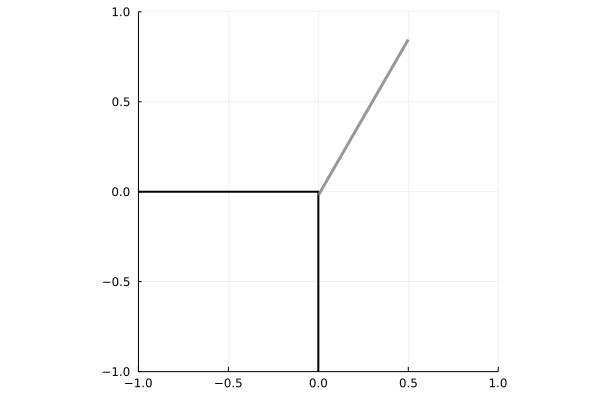

In [353]:
n = length(sol.t)
interval_n = 20
# n = Int(floor(0.77/Δt))
x = zeros(Int(floor(n/interval_n))+1)
y = zeros(Int(floor(n/interval_n))+1)
θ = zeros(Int(floor(n/interval_n))+1)
for i = 1:interval_n:n
    k = Int(floor(i/interval_n)+1)
    x[k] = sol.u[i][1]
    y[k] = sol.u[i][2]
    θ[k] = sol.u[i][3]
end

RodWorld.animation(x,y,θ,Int(floor(n/interval_n))+1)

debug takeaway:

* Control not stable: use smaller control step size
* Simulation not expected: use smaller step size
* need to use right distance function (compute_a) and correct contact constraints matrix (compute_A), compute_A don't have to be the jacobian of compute_a. 
* For event-detection, you can hack a bit according to the actual case
